[Lecture 0](https://youtu.be/sx8AEwm7kJc)


[View in Colaboratory](https://colab.research.google.com/github/schwaaweb/aimlds1_06-TheMachineLearningFramework/blob/master/M06_A--Regression_is_Predictions_Assignment.ipynb)

# Regression is Prediction

## Linear Regression

You all know the equation for a line, $y = mx+b$, or in the language of ML $f(x) = mx+b$. Two points are "produced" by $f(x)$:

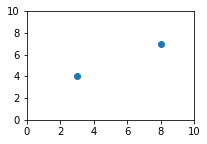

In [42]:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn, optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_two():
  x = [3,8]
  y = [4,7]
  plt.figure(figsize=(3,2))
  plt.plot(x,y,'o')
  plt.xlim(0,10)
  plt.ylim(0,10)

plot_two()

It is easy to solve $f(x) = mx+b$ for the above two points. We don't have to! There are many implementations of linear regression in the `python` universe.

In [44]:
p = np.polyfit(x,y,1)

NameError: name 'x' is not defined

So, $f(x) = \frac{3}{5}x + 2\frac{1}{5}$

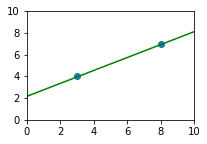

In [45]:
# Really weird - the line drawn in this graph doesn't quite intersect the points
# how I expected. I tweaked the values to make it suit my Mark-One-Eyeball
# better. I suspect that the discrepancy is actually caused by the graph.
def f(x):
  return 0.595*x + 2.16
plot_two()
xs = np.linspace(0,10,11)
plt.plot(xs,f(xs),c='g');

## Co-Linearity

The above two points we used to generate $f(x)$ lie on the same line. Any pair of points lie on the same line - a line is defined by two points. Every other point on the line is co-linear with the first two. If we had three points all defined by $f(x)$, the result of `np.polyfit` would be the same.

What about when the points are not co-linear, but instead are merely covariant?

/Users/darwinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


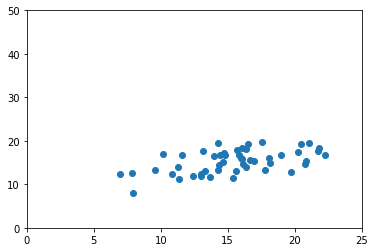

In [46]:
def plot_many(points):
  plt.scatter(*points.T)
  plt.xlim(0,25)
  plt.ylim(0,50)
  
points = np.random.multivariate_normal([15,15],[[12,6],[1,6]],50)
plot_many(points)

In [47]:
x, y = points.T
p2 = np.polyfit(x,y,1)
print(p2)

[0.38587403 9.32954253]


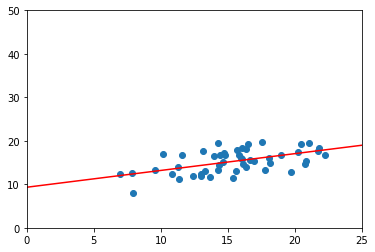

In [48]:
def f2(x):
  return p2[0] * x + p2[1]
plot_many(points)
nx = np.linspace(0,25,26)
plt.plot(nx,f2(nx),c='r');
  

# Regression by Gradient Descent

Linear regression is implemented by a multitude of libraries:

[A bunch of ways](https://medium.freecodecamp.org/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b)

You will never need to implement linear regression by hand, except right now! Linear regression is great because it has an analytic solution to the system of equations $Ax = b$, which can be computed via matrix multiplies:

$x = (A^TA)^{-1}A^Tb$

However, it is also trivial to compute the same solution via gradient descent. Remember those function gradients we studied at the beginning of class?



/Users/darwinm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


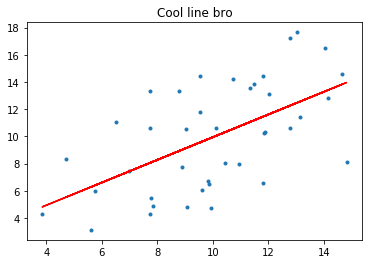

In [49]:
# LAMBDA SCHOOL
# 
# MACHINE LEARNING
#
# MIT LICENSE

import numpy as np
import matplotlib.pyplot as plt

points = np.random.multivariate_normal([10,10],[[10,10],[0,10]],40)
x,y = points.T
solution = np.polyfit(x,y,1)
plt.plot(x,y,marker='.',lineStyle="None");
plt.plot(x,x*solution[0] + solution[1],c='r');
plt.title('Cool line bro');

The solution is just a pair of scalars, $m$ and $b$. What if we pick them at random?

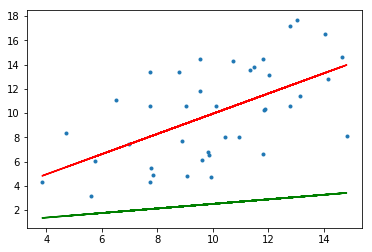

In [50]:
m = np.random.random()
b = np.random.random()

# How is this solution?
plt.plot(x,y,marker='.',lineStyle="None");
plt.plot(x,x*solution[0] + solution[1],c='r');
plt.plot(x,m*x + b,c='g');

## Root-mean Squared Error (RMSE)

RMSE is the most common "loss function", that is, a way of measuring the error in a model prediction. The error of a prediction is the difference between the values it predicted and the values that were expected.

RMSE is calculated:

$RMSE = \sqrt{\frac{\sum_{t=1}^T \left( \hat{y_t} - y_t \right) ^2}{T}}$

$\hat{y_t}$ is the prediction of the model for a particular sample $t$. $y_t$ is the true label for sample $t$.

Linear regression is the proess of minimizing the least-squared error between the line-of-regression and the sample points.

If we calculate `polyfit` as above using `full=True`, it will return the error of the model computed by polyfit.

In [51]:
coefficients, residual, solution_rank, solution_singular_values, rcond_epsilon = np.polyfit(x,y,1,full=True)
print(coefficients)
print(residual)
print(solution_rank)
print(solution_singular_values)
print(rcond_epsilon)

[0.83323525 1.61012385]
[408.3807676]
2
[1.40199986 0.18546264]
8.881784197001252e-15


Of particular interest here is the residual - this number is the MSE of the solution returned by `polyfit`. Can we reproduce it?

What about the residual of the line we just guessed at?

In [52]:
confirm_residual = np.sum((x*coefficients[0] + coefficients[1] - y)**2)
print(confirm_residual)

random_residual = np.sum((x*m+b-y)**2)
print(random_residual)

408.3807676024031
2744.4469612086573


### Loss function

The goal of gradient descent is to minimize the loss function - in this case, the loss function being RMSE of our estimated line. Without `polyfit`, we'd try to minimize the loss function all the way to 0, but `polyfit` has already calculated the best possible result! $MSE = 419$, $RMSE = \sqrt{419}$.

## Gradient Descent

`polyfit` determined that the best possible solution for $f(x) = mx+b$ is `coefficients[0] * x + coefficients[1]`. For any other value of `m` and `b`, the error (or RMSE), will be larger. The error function, RMSE is $\sqrt(mx+b-y)^2$

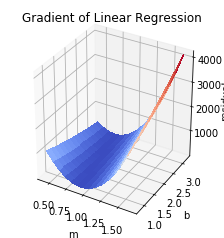

In [53]:
def mse(x,prediction_m,prediction_b,true_m,true_b):
  width = len(prediction_m)
  height = len(prediction_m[0])
  result = np.zeros(width*height).reshape(width,height)
  for row in range(width):
    for col in range(height):
      # calculate the RMSE of prediction_m/b, store in result
      m = prediction_m[row][col]
      b = prediction_b[row][col]
      result[row][col] = np.sum(((x*m+b)-(x*true_m+true_b))**2)
  return result

m_range = np.linspace(coefficients[0]*0.5, 2*coefficients[0], 15)
b_range = np.linspace(coefficients[1]*0.5, 2*coefficients[1], 15)
mm, bb = np.meshgrid(m_range,b_range)
Z = mse(x,mm,bb,coefficients[0],coefficients[1])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(mm, bb, Z, rstride=1, cstride=1, cmap=cm.coolwarm,\
                       linewidth=0, antialiased=False)
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('residual')
ax.set_title('Gradient of Linear Regression');

### Gradient Descent by Partial Derivative

The error function $E_{rms} = \sum{\sqrt{(\hat y_i - y_i)^2}}$ is differentiable: that is, we can find the derivative of the error function, which informs us how to update the parameters to minimize it. A model with zero error is perfect.

One of the foundations of machine learning is taking the partial derivative of the error function. When the error function is well defined like above, the gradient can be computed analytically. When it is not well defined, it can be computed using the method of finite differences which we studied in week 1. Lets drop the $\sqrt{}$ to make the derivative easier:

$E_{rms} = \sum{(\hat y_i - y_i)^2} = \sum{(mx_i + b - y_i)^2}$

We can't drop the $^2$, because that's what makes this a minimization problem.

We have two variables $m$ and $b$ that we'd like to solve for:

$\frac{\partial}{\partial m} = -2\sum x(mx_i + b - y)$

$\frac{\partial}{\partial b} = -2\sum (mx_i + b - y)$

See
* [ML Cheatsheet](http://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html)

and
* [MCCormickML](http://mccormickml.com/2014/03/04/gradient-descent-derivation/)

(0.9570954327069433, 0.2814825560955065, 10.328873549452974)


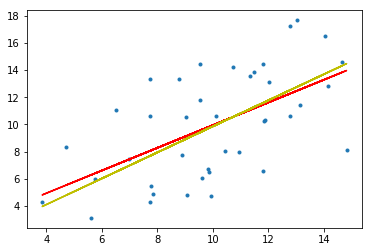

In [54]:
def linear_regression(X, y, m_current=0, b_current=0, epochs=10000, learning_rate=0.0001):
   N = float(len(y))
   for i in range(epochs):
        y_current = (m_current * X) + b_current
        cost = sum([data**2 for data in (y-y_current)]) / N
        m_gradient = -(2/N) * sum(X * (y - y_current))
        b_gradient = -(2/N) * sum(y - y_current)
        m_current = m_current - (learning_rate * m_gradient)
        b_current = b_current - (learning_rate * b_gradient)
   return m_current, b_current, cost

m_solution = linear_regression(x, y)
print(m_solution)
plt.plot(x,y,'o',marker='.')
plt.plot(x,x*solution[0]+solution[1],c='r')
plt.plot(x,x*m_solution[0]+m_solution[1],c='y')

# Your Assignment

Use gradient descent on the Titanic dataset.

* 1) Load and clean the data
* 1.1) Pay special attention to outliers. How will your model perform with and without outliers?
* 2) Identify which features are scalar values
* 3) Compute the linear regression of these values (there are only two predictable Y values)
* 3.1) Choose a set of features (columns) from Titanic and see which features minimize your RMSE
* 4) Report on your RMSE (residual error) for each of the models that you produce.
Linear regression works well with univariate data (that is, $dim(x) = 1 \times n$ and $dim(y) = 1 \times n$) or with multivariate data: $dim(x)) = m\times n$. Report your best regression selected from the data in the univariate case and the multivarate case. How do they differ?
* 5) Would this RMSE successfully produce good predictions on the Titanic scalar values?

In [55]:
# Complete assignment here.
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic_raw = titanic
#titanic = titanic.drop(['alive','adult_male','who','class','embark_town'], axis=1)
titanic0 = titanic_raw.drop(['deck'], axis=1)
titanic0['age'] = titanic0['age'].fillna(method='ffill')
titanic0['embarked'].fillna(titanic0['embarked'].value_counts().index[0], inplace=True)
titanic0['embark_town'].fillna(titanic0['embark_town'].value_counts().index[0], inplace=True)
titanic = titanic0.drop(['alive', 'adult_male', 'who', 'class', 'embark_town'], axis=1)

Any more NaN?
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64
   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male  embark_town alive  alone  
0    man        True  Southampton    no  False  
1  woman       False    Cherbourg   yes  False  
2  woman       False  Southampton   yes   True  
3  woman       False  Southampton   yes  False  
4    man        True  Southampton

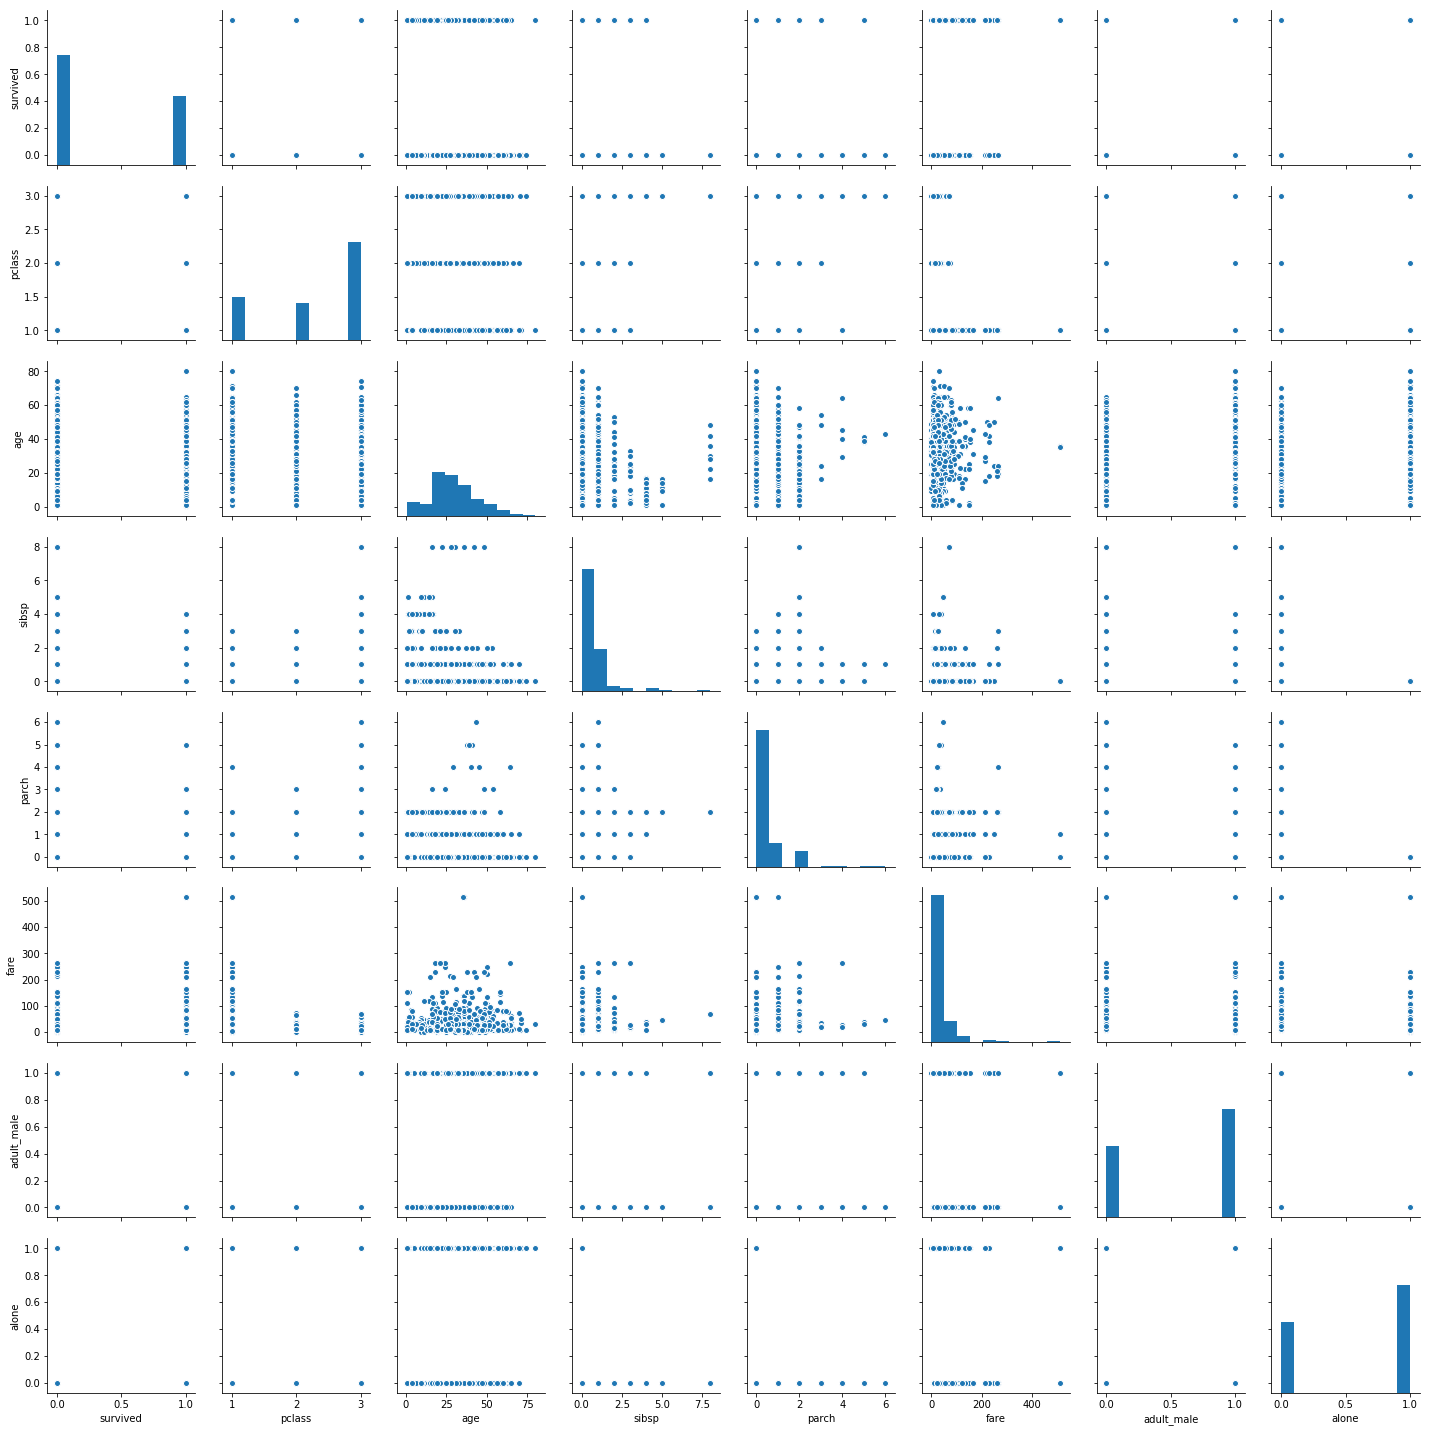

In [56]:
print('Any more NaN?')
print(titanic0.isna().sum())
print(titanic0.head())
sns.pairplot(titanic0)

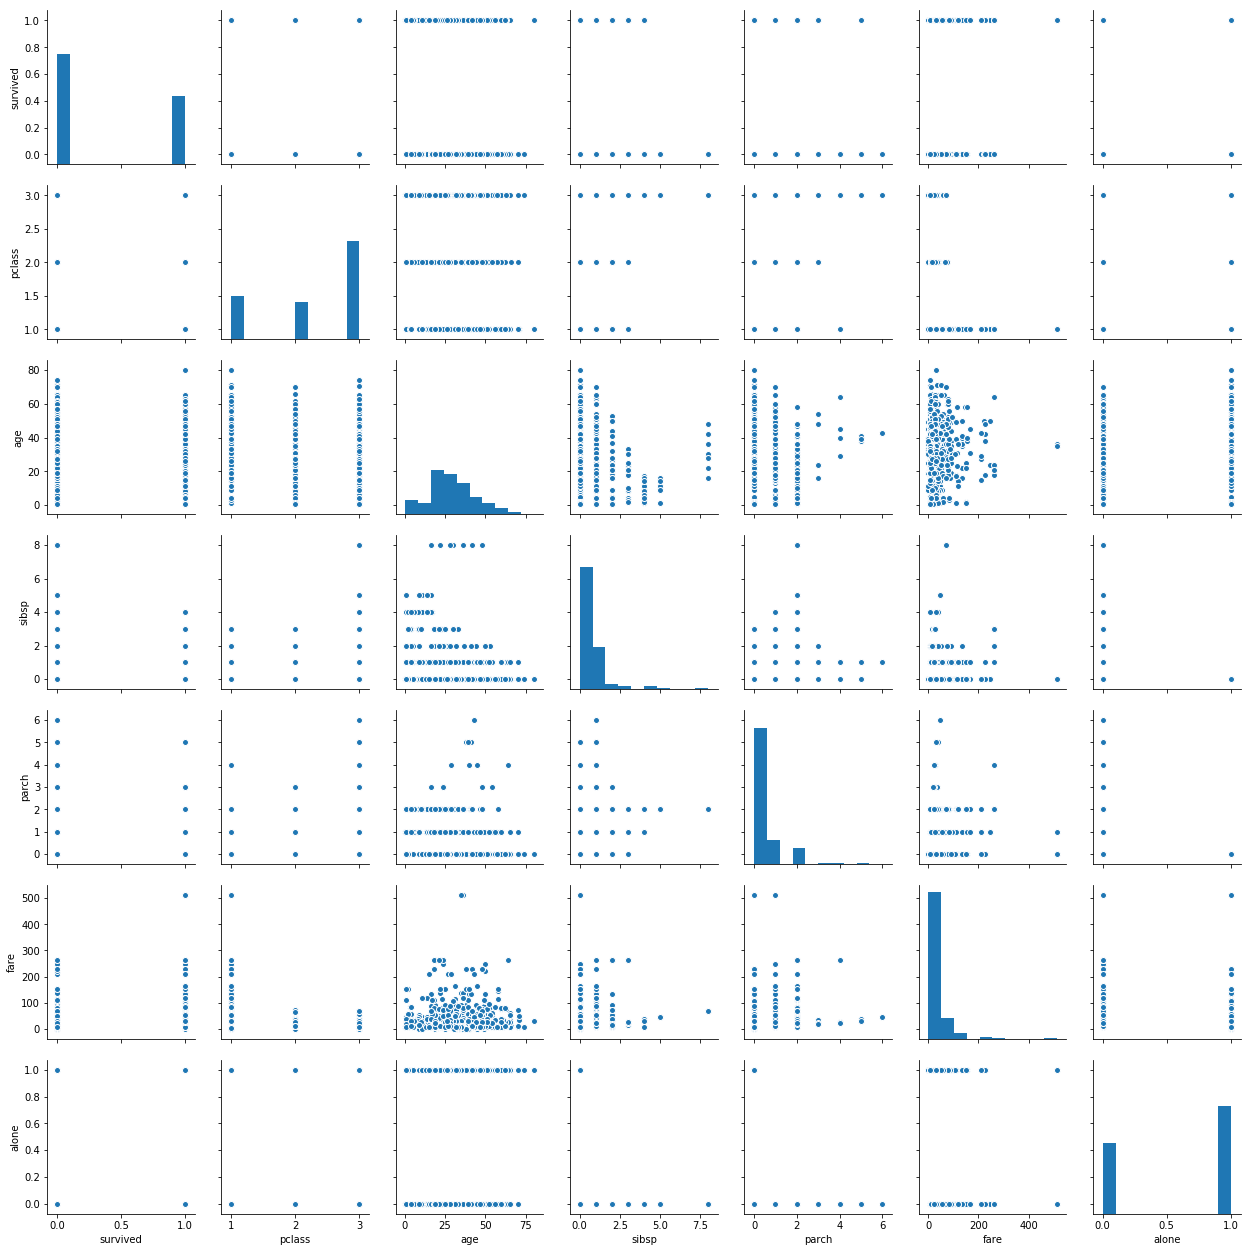

In [28]:
sns.pairplot(titanic);

In [58]:
def darwin_ecdf(dfd):
    percentiles = np.array([25,50,75])
    percent_marks = np.percentile(titanic[dfd], percentiles)
    xs = np.sort(titanic[dfd])
    ys = np.arange(1, len(xs) + 1)/len(xs)
    plt.plot(xs, ys, marker='.',linestyle='none');
    plt.plot(percent_marks, percentiles/100, marker='D', color='orange', linestyle='none')
    plt.title(dfd)
    plt.show()

titanic0.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True


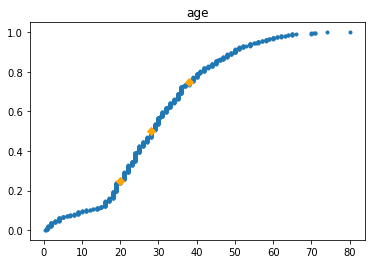

In [59]:
titanic_cat = ['age', 'fare']
darwin_ecdf(titanic_cat[0])

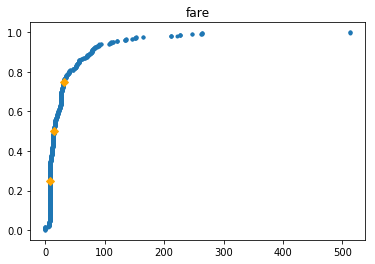

In [60]:
darwin_ecdf(titanic_cat[1])

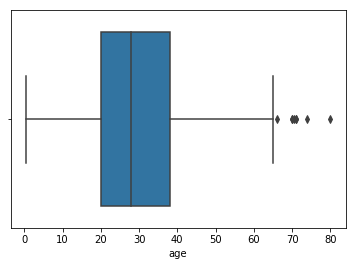

In [61]:
sns.boxplot(x='age',data=titanic)

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

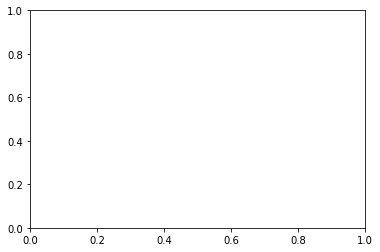

In [63]:
plt.scatter(titanic['age'],titanic['fare'], 'og');

## Stretch Goal

Lets get started on Kaggle.

[House Prices Advanced Regression](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Sign up to compete, and download the dataset! The Zillow data contains a huge number of columns. Spend an hour or two studying the data, cleaning it, and configuring it, then work to use `polyfit` (remember, it is your first ML model) to make predictions about the final column `SalePrice`.


# Thinking about your assignment

1. What am I being asked to do?
2. What coding steps need to be taken to satisfy the problem?
3. What must I do to claim that I have "completed" the assignment?

# Useful Google Terms to solve the above

* objectives based instruction design
* backwards driven design lesson planning
* writing assignments to engage beginner and advanced students...